In [1]:
import bagpy
import numpy as np
import pandas as pd
import seaborn as sns
from bagpy import bagreader
import matplotlib.pyplot as plt

In [2]:
!ls

bad_stationary_analysis.ipynb
bad_walking_analysis.ipynb
good_stationary_analysis.ipynb
good_walking_analysis.ipynb
moving_bad_data_2022-10-06-15-51-25
moving_bad_data_2022-10-06-15-51-25.bag
moving_good_data_2022-10-06-16-14-14
moving_good_data_2022-10-06-16-14-14.bag
stationary_bad_data_2022-10-06-15-37-46
stationary_bad_data_2022-10-06-15-37-46.bag
stationary_good_data_2022-10-06-16-02-30
stationary_good_data_2022-10-06-16-02-30.bag


In [3]:
b = bagreader('moving_good_data_2022-10-06-16-14-14.bag')
gps_data = b.message_by_topic('/coordinates')
df_gps = pd.read_csv(gps_data)

[INFO]  Data folder moving_good_data_2022-10-06-16-14-14 already exists. Not creating.


In [4]:
df_gps

,Time,easting,northing,altitude,zone_number,zone_letter,rtk_fix
0,1.665087e+09,328085.277986,4.689334e+06,16.3,19,T,4
1,1.665087e+09,328085.979053,4.689334e+06,16.3,19,T,4
2,1.665087e+09,328086.794054,4.689335e+06,16.3,19,T,4
3,1.665087e+09,328087.638331,4.689336e+06,16.3,19,T,5
4,1.665087e+09,328088.457419,4.689337e+06,16.3,19,T,5
...,...,...,...,...,...,...,...
75,1.665087e+09,328083.838466,4.689337e+06,16.4,19,T,4
76,1.665087e+09,328084.779628,4.689336e+06,16.5,19,T,4
77,1.665087e+09,328085.654862,4.689335e+06,16.4,19,T,4
78,1.665087e+09,328086.069159,4.689335e+06,16.4,19,T,4


In [5]:
df_gps['Time'] = df_gps['Time'] - min(df_gps['Time'])

In [6]:
df_gps['easting'] = df_gps['easting'] - np.mean(df_gps['easting'])

In [7]:
df_gps['northing'] = df_gps['northing'] - np.mean(df_gps['northing'])

In [8]:
df_gps

,Time,easting,northing,altitude,zone_number,zone_letter,rtk_fix
0,0.000000,-11.054546,-17.315466,16.3,19,T,4
1,0.965777,-10.353479,-16.740088,16.3,19,T,4
2,1.967333,-9.538479,-16.000842,16.3,19,T,4
3,2.999134,-8.694201,-15.188242,16.3,19,T,5
4,3.990362,-7.875113,-14.282433,16.3,19,T,5
...,...,...,...,...,...,...,...
75,74.981565,-12.494066,-14.391298,16.4,19,T,4
76,75.971515,-11.552904,-15.229196,16.5,19,T,4
77,77.004457,-10.677670,-15.954367,16.4,19,T,4
78,78.003748,-10.263373,-16.427490,16.4,19,T,4


In [9]:
def plot_graph(xax, yax, units_x, units_y, scatter=False):
    if scatter:
        plt.scatter(df_gps[xax].tolist(), df_gps[yax].tolist())
    else:
        plt.plot(df_gps[xax].tolist(), df_gps[yax].tolist())
    plt.xlabel(f'{xax}({units_x})')
    plt.ylabel(f'{yax}({units_y})')
    plt.title(f'{yax} vs {xax}')
    plt.show()

In [10]:
x = df_gps['northing'].tolist()
y = df_gps['easting'].tolist()

x_min = min(x)
y_min = min(y)
print(x_min, y_min)

x_max = max(x)
y_max = max(y)
print(x_max, y_max)

-17.315465713851154 -16.176643996383063
17.241238871589303 16.806451915530488


In [11]:
def get_df_bounds(a, b):
    if a < b:
        lb = a
        ub = b
    else:
        lb = b
        ub = a
    return lb, ub

In [12]:
def get_line_fn(x, y, time_factor):
    coeffs = np.polyfit(x, y, 1)
    poly = np.poly1d(coeffs)
    
    x0, x1, y0, y1 = int(x[0]), int(x[1]), int(y[0]), int(y[1])
    x_lb, x_ub = get_df_bounds(x0, x1)
    y_lb, y_ub = get_df_bounds(y0, y1)
    
    plot_df = df_gps[df_gps['northing'].between(x_lb, x_ub, inclusive=False)][['Time', 'northing', 'easting']]
#     print(plot_df)
    
    times = plot_df['Time'].to_list()
    
    if time_factor:
        break_i = times[-1] + 1
        prev_t = 0
        for i in range(len(times)):
            t = times[i]
            if t - prev_t > 2:
                break_i = i
            prev_t = t
        
#         print('b', break_i)
        plot_df = plot_df.iloc[0: break_i]
    
    else:
        break_i = -1
        prev_t = times[-1]
        for i in range(len(times) - 1, 0, -1):
            t = times[i]
            if abs(t - prev_t) > 2:
                break_i = i
            prev_t = t
            
#         print('b', break_i)
        plot_df = plot_df.iloc[break_i+1:]
    
#     print()
#     print(plot_df)
    x_plot = plot_df['northing'].to_list()
    y_true = plot_df['easting'].to_list()
#     print()

    y_plot = poly(x_plot)
#     y_true = df_gps[df_gps['easting'].between(y_plot[0], y_plot[-1], inclusive=False)]['easting'].to_list()
    
#     print(len(x_plot), len(y_plot), len(y_true))
    
    return poly, x_plot, y_plot, y_true

In [13]:
ll_x = [-17, -9.7]
ll_y = [-9.7, -17]

rl_x = [12, 17]
rl_y = [17, 12]

tl_x = [-17, 12]
tl_y = [-11, 18]

bl_x = [-10, 17]
bl_y = [-17, 10]

ll_poly, ll_x_plot, ll_y_plot, ll_y_true = get_line_fn(ll_x, ll_y, False)
rl_poly, rl_x_plot, rl_y_plot, rl_y_true = get_line_fn(rl_x, rl_y, True)
tl_poly, tl_x_plot, tl_y_plot, tl_y_true = get_line_fn(tl_x, tl_y, True)
bl_poly, bl_x_plot, bl_y_plot, bl_y_true = get_line_fn(bl_x, bl_y, False)

/tmp/ipykernel_20553/3327171454.py:9: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  plot_df = df_gps[df_gps['northing'].between(x_lb, x_ub, inclusive=False)][['Time', 'northing', 'easting']]
/tmp/ipykernel_20553/3327171454.py:9: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  plot_df = df_gps[df_gps['northing'].between(x_lb, x_ub, inclusive=False)][['Time', 'northing', 'easting']]
/tmp/ipykernel_20553/3327171454.py:9: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  plot_df = df_gps[df_gps['northing'].between(x_lb, x_ub, inclusive=False)][['Time', 'northing', 'easting']]
/tmp/ipykernel_20553/3327171454.py:9: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  plot_df = df_gps[df_gps['northing'].between(x_lb, x_ub, inclusive=False)][['Time', 'northin

Text(0.5, 1.0, 'ideal path vs obtained path')

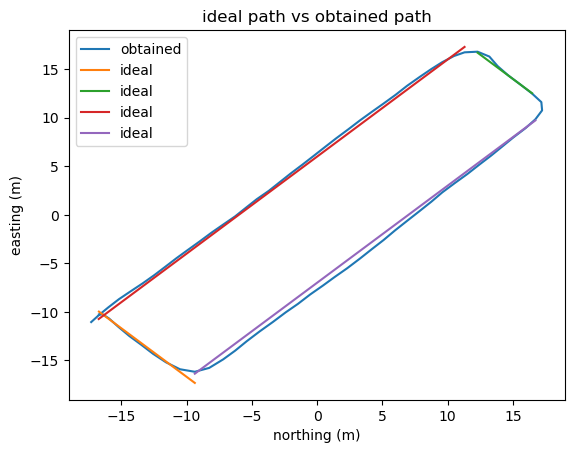

In [14]:
plt.plot(df_gps['northing'].tolist(), df_gps['easting'].tolist(), label='obtained')
# plt.plot(ll_x_plot, ll_y_true)
# plt.plot(rl_x_plot, rl_y_true)
# plt.plot(tl_x_plot, tl_y_true)
# plt.plot(bl_x_plot, bl_y_true)

plt.plot(ll_x_plot, ll_y_plot, label='ideal')
plt.plot(rl_x_plot, rl_y_plot, label='ideal')
plt.plot(tl_x_plot, tl_y_plot, label='ideal')
plt.plot(bl_x_plot, bl_y_plot, label='ideal')

plt.xlabel('northing (m)')
plt.ylabel('easting (m)')
plt.legend()
plt.title('ideal path vs obtained path')

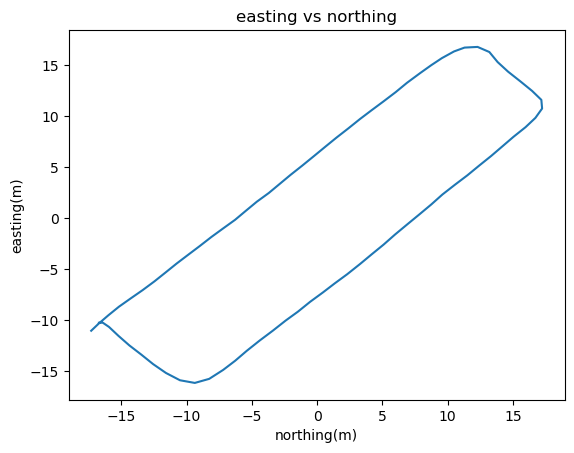

In [15]:
plot_graph('northing', 'easting', 'm', 'm')

In [16]:
def get_rmse(ys, y_ideals):
    rmse = 0
    for i in range(len(ys)):
        rmse += np.sqrt(np.square(ys[i] - y_ideals[i]).mean())
    rmse /= len(ys)
    return rmse

In [17]:
ys = [ll_y_plot, rl_y_plot, tl_y_plot, bl_y_plot]
y_ideals = [ll_y_true, rl_y_true, tl_y_true, bl_y_true]
get_rmse(ys, y_ideals)

0.37503852699986157

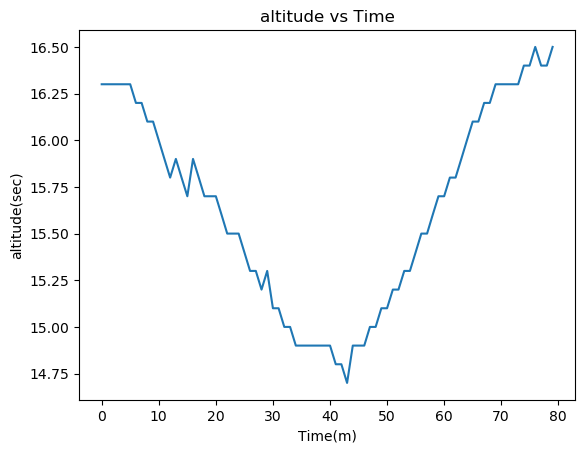

In [18]:
plot_graph('Time', 'altitude', 'm', 'sec')

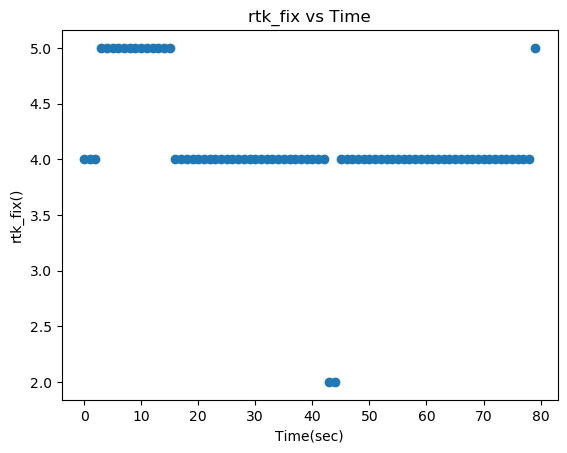

In [19]:
plot_graph('Time', 'rtk_fix', 'sec', '', True)